In [16]:
import numpy as np 
import pandas as pd 
import os
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [17]:
data = pd.read_csv('testset.csv')
data.head()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10416 entries, 0 to 10415
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10416 non-null  object 
 1   Open    10416 non-null  float64
 2   Close   10416 non-null  float64
dtypes: float64(2), object(1)
memory usage: 244.2+ KB


In [18]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()


C:\Users\Hufal\AppData\Local\Temp/ipykernel_6224/552766564.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


,Date,Open,Close
0,12/12/1980,0.128348,0.128348
1,15/12/1980,0.122210,0.121652
2,16/12/1980,0.113281,0.112723
3,17/12/1980,0.115513,0.115513
4,18/12/1980,0.118862,0.118862


In [19]:
data.isnull().sum()

Date     0
Open     0
Close    0
dtype: int64

In [20]:
df=data

In [21]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

8251
2063


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError


In [23]:
model = tf.keras.Sequential()
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [24]:
history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)


Epoch 1/40
207/207 [==============================] - 13s 29ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.1116 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0491
Epoch 2/40
207/207 [==============================] - 5s 22ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0853 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0515
Epoch 3/40
207/207 [==============================] - 4s 21ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0838 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0452
Epoch 4/40
207/207 [==============================] - 4s 21ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0793 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0440
Epoch 5/40
207/207 [==============================] - 4s 20ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0794 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0467
Epoch 6/40
207/207 [==============================] - 4s 21ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0772 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0455
Epoch 7/4

In [25]:
model.evaluate(test_X, test_Y)

65/65 [==============================] - 0s 6ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0520


[0.004679618403315544, 0.004679618403315544, 0.05204108729958534]

In [26]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


yhat_probs = model.predict(test_X, verbose=0)

yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.867589
R2 Score: 0.867589
Max Error: 0.368032


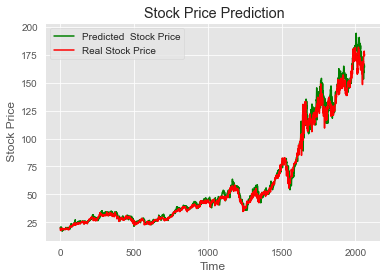

In [27]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,2]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_label,predicted)
mse

21.32765493501242

In [29]:
rmse = np.sqrt(mse)
rmse

4.618187407956981

In [29]:
model.save("model-cnn-noshuffle.h5")

In [30]:
from tensorflow import keras
yActual = test_label
yPredicted = predicted
 
mapeObject = keras.losses.MeanAbsolutePercentageError()
mapeTensor = mapeObject(yActual, yPredicted)
mape = mapeTensor.numpy()
 
print(mape)

4.6364927
